Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по [ссылке](https://github.com/a4tunado/lectures/tree/master/006). Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.
[Датасет](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

**Классификация изображений: Cats vs Dogs**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import zipfile
%matplotlib inline
from matplotlib import pyplot as plt
import re
import os
from random import shuffle
from glob import glob
from sklearn.metrics import log_loss
from keras.optimizers import RMSprop

print(tf.__version__)
print(tf.executing_eagerly())

2.9.2
True


**Функции загрузки данных**

In [ ]:
!wget -O dogs-vs-cats.zip "https://www.dropbox.com/s/rxs0lxfauujpgih/dogs-vs-cats.zip?dl=1"

--2023-01-23 11:03:13--  https://www.dropbox.com/s/rxs0lxfauujpgih/dogs-vs-cats.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/rxs0lxfauujpgih/dogs-vs-cats.zip [following]
--2023-01-23 11:03:14--  https://www.dropbox.com/s/dl/rxs0lxfauujpgih/dogs-vs-cats.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0003a77f42fa44db2b717c3827.dl.dropboxusercontent.com/cd/0/get/B1G0MB-8hHGjFQ28IqzxjhOUdb1XFPtiJ4Yz5tMx09dx6lq_C1V56T9glbsGagNu1lwBCanI1hhc7ClkqiQOQEFeEaADhwdzWAhjkiRVig0OHFzqnsHELNZ3VOcgfPpEo5-pI90F9qJ2m0nG2_kNyUHdK3ciMjDnb2GuOORYAQoZbA/file?dl=1# [following]
--2023-01-23 11:03:14--  https://uc0003a77f42fa44db2b717c3827.dl.dropboxusercontent.com/cd/0/get/B1G0MB-8hHGjFQ28IqzxjhOUdb1XFPtiJ4Yz5tMx09dx6lq_C1V56T9glbsGagNu

In [ ]:
!unzip dogs-vs-cats.zip
!unzip train.zip
!unzip test1.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/5

In [ ]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('train/*.jpg')
test_files = glob('test1/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=100):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])


**Визуализируем примеры для обучения**

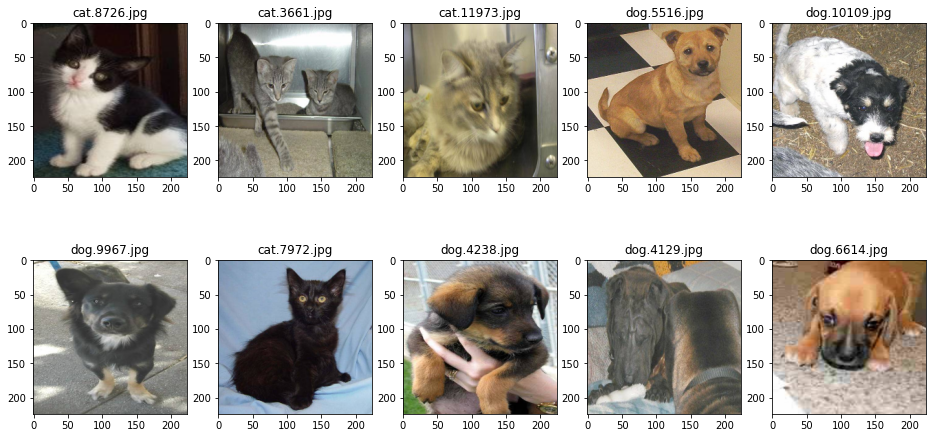

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

**Загружаем предобученную модель**

In [ ]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Добавляем полносвязный слой**

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

**Выводим архитектуру модели**

In [ ]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

**Компилируем модель и запускаем обучение**

In [ ]:
optimizer = RMSprop(learning_rate=1e-5)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=200,  # число вызовов генератора за эпоху
          epochs=25,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/25
200/200 [==============================] - 136s 593ms/step - loss: 0.2872 - accuracy: 0.8752 - val_loss: 0.5539 - val_accuracy: 0.6000
Epoch 2/25
200/200 [==============================] - 115s 574ms/step - loss: 0.1361 - accuracy: 0.9508 - val_loss: 0.7842 - val_accuracy: 0.4000
Epoch 3/25
200/200 [==============================] - 115s 575ms/step - loss: 0.0853 - accuracy: 0.9729 - val_loss: 0.5920 - val_accuracy: 0.8000
Epoch 4/25
200/200 [==============================] - 115s 574ms/step - loss: 0.0594 - accuracy: 0.9857 - val_loss: 0.7612 - val_accuracy: 0.4000
Epoch 5/25
200/200 [==============================] - 115s 576ms/step - loss: 0.0426 - accuracy: 0.9916 - val_loss: 0.6710 - val_accuracy: 0.8000
Epoch 6/25
200/200 [==============================] - 115s 575ms/step - loss: 0.0280 - accuracy: 0.9967 - val_loss: 0.5966 - val_accuracy: 0.8000
Epoch 7/25
200/200 [==============================] - 115s 576ms/step - loss: 0.0224 - accuracy: 0.9977 - val_loss: 0.7568 -

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

**Предсказания на проверочной выборке**

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 113s 9ms/step


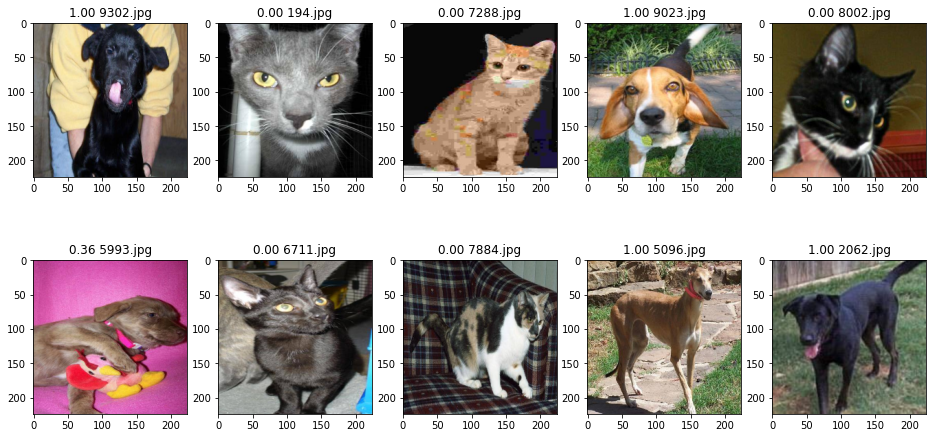

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

**Готовим данные для отправки**

In [ ]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
!head submit.csv

id,label
9302,0.999972
194,0.000042
7288,0.002467
9023,0.999994
8002,0.000012
5993,0.356553
6711,0.001723
7884,0.000207
5096,0.999863


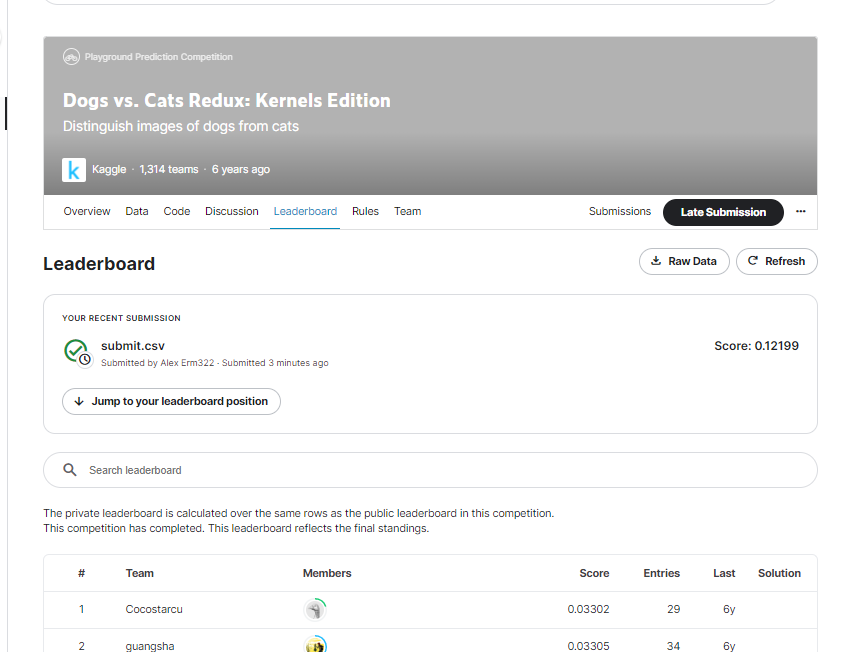

Комментарии:

Дополнительно можно изучить [статью](https://habr.com/ru/company/sciberia/blog/499672/).
Работа выполнена отлично, у меня нет замечаний

ДЗ зачтено!